<font size="+3"><strong>4.3. Predicting Damage with Decision Trees</strong></font>

In [1]:
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
from category_encoders import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.validation import check_is_fitted



## Import

In [2]:
def wrangle(filepath):
    # Connect to database
    # conn = sqlite3.connect(db_path)

    # # Construct query
    # query = """
    #     SELECT distinct(i.building_id) AS b_id,
    #        s.*,
    #        d.damage_grade
    #     FROM id_map AS i
    #     JOIN building_structure AS s ON i.building_id = s.building_id
    #     JOIN building_damage AS d ON i.building_id = d.building_id
    #     WHERE district_id = 4
    # """

    # Read query results into DataFrame
    df = pd.read_csv(filepath, index_col="b_id")

    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]

    # Add high-cardinality / redundant column
    drop_cols.append("building_id")

    # Create binary target column
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

    # Drop old target
    drop_cols.append("damage_grade")

    # Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")

    # Drop columns
    df.drop(columns=drop_cols, inplace=True)

    return df

**Task 4.3.1:** Use the `wrangle` function above to import your data set into the DataFrame `df`. The path to the SQLite database is `"/home/jovyan/nepal.sqlite"`


In [4]:
df = wrangle("../data/raw/kavrepalanchok_raw.csv")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
87473,15,382,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87479,12,328,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,"Stone, mud mortar",1
87482,23,427,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87491,12,427,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87496,32,360,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1


**Task 4.3.2:** Create your feature matrix `X` and target vector `y`. Your target is `"severe_damage"`. 

In [5]:
target = "severe_damage"
X = df.drop(columns=['severe_damage'])  # Features (all columns except 'Target')
y = df[target]

**Task 4.3.3:** Divide your data (`X` and `y`) into training and test sets using a randomized train-test split. Your test set should be 20% of your total data. And don't forget to set a `random_state` for reproducibility. 


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

**Task 4.3.4:** Divide your training data (`X_train` and `y_train`) into training and validation sets using a randomized train-test split. Your validation data should be 20% of the remaining data. Don't forget to set a `random_state`.

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
 
    X_train, y_train, test_size=0.2, random_state=42
)

**Task 4.3.5:** Calculate the baseline accuracy score for your model.


In [8]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.55


**Task 4.3.6:** Create a pipeline named `model` that contains a `OrdinalEncoder` transformer and a `DecisionTreeClassifier` predictor. (Be sure to set a `random_state` for your predictor.) Then fit your model to the training data. 


In [9]:
# Build Model
model = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=6, random_state=42) 
)
# Fit model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
E-shape                             9
Building with Central Courtyard    10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                                          'data_type': dtype('O'),
                                          'mapping': Stone, mud mortar        1
Adobe/mud                2
Brick, mud mortar        3
Brick, cement mortar     4
RC, non-engineered       5
RC, engineered           6
Stone, cement mortar     7
Timber                   8
Other                    9
Bamboo                  10
Stone                   11
NaN                     -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=6, random_state=42))])

**Task 4.3.7:** Calculate the training and validation accuracy scores for your models. 


In [10]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_val = model.score(X_val, y_val)

print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.66
Validation Accuracy: 0.65


**Task 4.3.8:** Use the [`get_depth`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.get_depth) method on the `DecisionTreeClassifier` in your model to see how deep your tree grew during training. 


In [11]:
tree_depth = model.named_steps["decisiontreeclassifier"].get_depth()
print("Tree Depth:", tree_depth)

Tree Depth: 6


**Task 4.3.9:** Create a range of possible values for `max_depth` hyperparameter of your model's `DecisionTreeClassifier`. `depth_hyperparams` should range from `1` to `50` by steps of `2`.


In [12]:
depth_hyperparams = range(1, 50, 2)

**Task 4.3.10:** Complete the code below so that it trains a model for every `max_depth` in `depth_hyperparams`. Every time a new model is trained, the code should also calculate the training and validation accuracy scores and append them to the `training_acc` and `validation_acc` lists, respectively. 


In [13]:
# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=d,random_state=42) 
    )
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.6400775826868109, 0.643834218048183, 0.654593711719069]
Validation Accuracy Scores: [0.6368610158419076, 0.6398824105830475, 0.6514780336436388]


**Task 4.3.11:** Create a visualization with two lines. The first line should plot the `training_acc` values as a function of `depth_hyperparams`, and the second should plot `validation_acc` as a function of `depth_hyperparams`. You x-axis should be labeled `"Max Depth"`, and the y-axis `"Accuracy Score"`. Also include a legend so that your audience can distinguish between the two lines. 


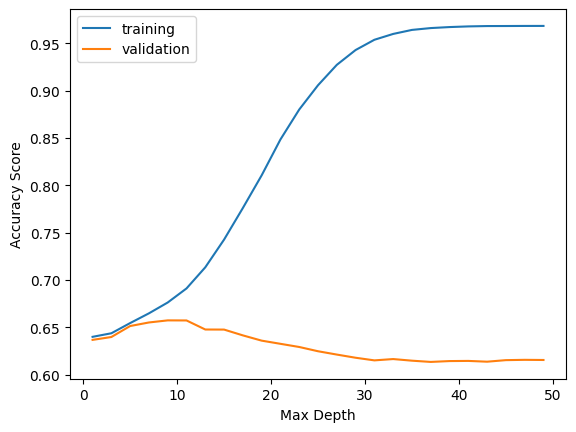

In [14]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams, training_acc, label="training")
plt.plot(depth_hyperparams, validation_acc, label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

**Task 4.3.12:** Based on your visualization, choose the `max_depth` value that leads to the best validation accuracy score. Then retrain your original model with that `max_depth` value. Lastly, check how your tuned model performs on your test set by calculating the test accuracy score below. Were you able to resolve the overfitting problem with this new `max_depth`?


In [15]:
test_acc = model.score(X_test, y_test)
print("Test Accuracy:", round(test_acc, 2))

Test Accuracy: 0.65


**Task 4.3.13:** Complete the code below to use the [`plot_tree`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) function from scikit-learn to visualize the decision logic of your model. 


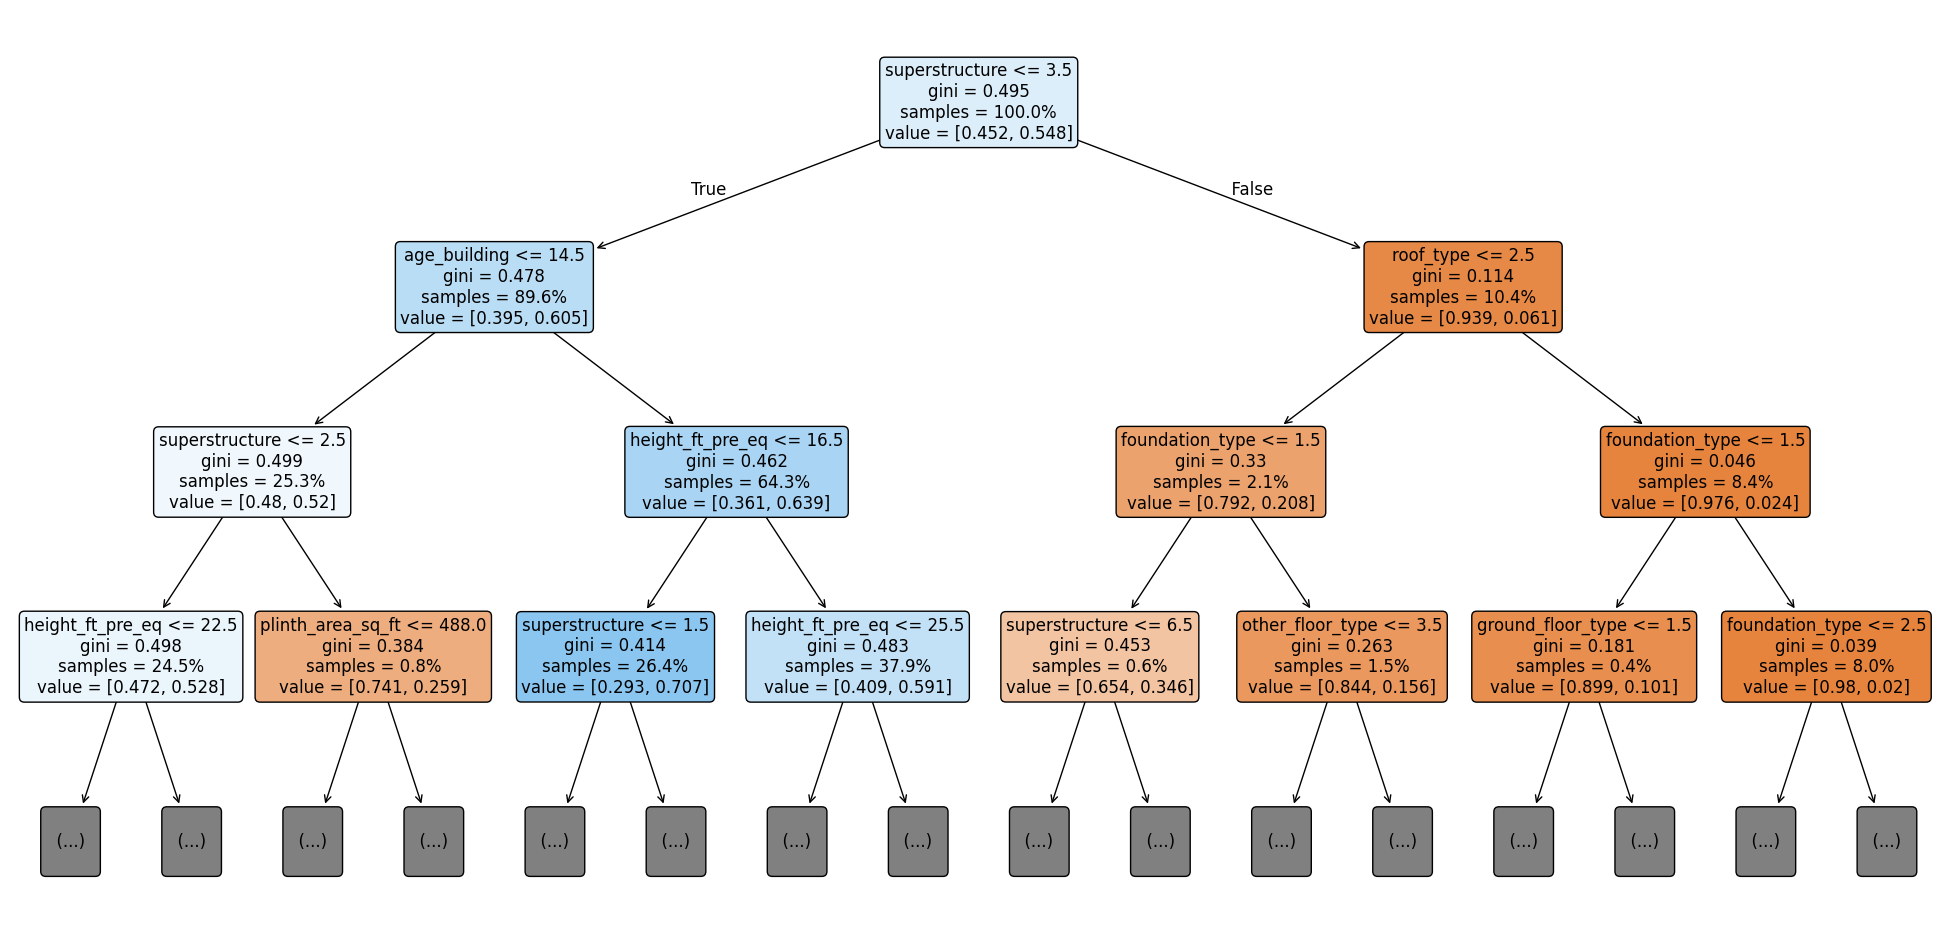

In [16]:
# Create larger figure
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    decision_tree=model.named_steps["decisiontreeclassifier"],
    feature_names=X_train.columns.to_list(),
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

**Task 4.3.14:** Assign the feature names and importances of your model to the variables below. For the `features`, you can get them from the column names in your training set. For the `importances`, you access the [`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_) attribute of your model's `DecisionTreeClassifier`. 


In [17]:
features = X_train.columns
importances = model.named_steps["decisiontreeclassifier"].feature_importances_

print("Features:", features[:3])
print("Importances:", importances[:3])

Features: Index(['age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq'], dtype='object')
Importances: [0.08033921 0.01394596 0.11152609]
